In [11]:
import os
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Set the directory and initial capital
directory = "SP500_00_25"
initial_capital = 10000
min_data_length = 2500  # At least 2500 rows of data
window_size = 300 # Number of days to use for calculating MVO
rebalance_period = 1  # Rebalance the portfolio every 1 day
max_selected_stocks = 100  # Maximum number of stocks to hold
risk_free_rate = 0 # Here it doesn't really affect the portfolio rate, just the Sharpe Ratio would be overestimated

print("✅ Initialization complete!")


✅ Initialization complete!


In [12]:
def load_data(directory):
    stock_data = {}
    for ticker in os.listdir(directory):
        if ticker.endswith(".csv"):
            file_path = os.path.join(directory, ticker)
            df = pd.read_csv(file_path)
            df['Date'] = pd.to_datetime(df['Date'])
            df.set_index('Date', inplace=True)
            df.sort_index(inplace=True)

            # Only select stocks with enough data (>= min_data_length)
            if df.shape[0] >= min_data_length:
                # Store both Open and Close prices for each stock
                stock_data[ticker.replace(".csv", "")] = df[['Close']]
    
    return stock_data

# Load the stock data
stock_data = load_data(directory)

# Preview the data of the first 5 stocks
for ticker in list(stock_data.keys())[:5]:
    print(f"📈 Sample data for {ticker}:\n", stock_data[ticker].head())

print(f"\n✅ Successfully loaded data for {len(stock_data)} stocks!")


📈 Sample data for TMUS:
                 Close
Date                 
2007-04-19  44.401424
2007-04-20  46.264980
2007-04-23  46.589085
2007-04-24  47.318306
2007-04-25  46.362221
📈 Sample data for CHRW:
                Close
Date                
2000-01-03  6.077981
2000-01-04  5.874091
2000-01-05  5.796419
2000-01-06  5.825543
2000-01-07  5.903218
📈 Sample data for COO:
                Close
Date                
2000-01-03  3.604824
2000-01-04  3.635373
2000-01-05  3.658286
2000-01-06  3.658286
2000-01-07  3.688835
📈 Sample data for ES:
                Close
Date                
2000-01-03  9.072895
2000-01-04  9.072895
2000-01-05  9.127709
2000-01-06  9.237353
2000-01-07  9.319588
📈 Sample data for HSIC:
                Close
Date                
2000-01-03  2.475490
2000-01-04  2.352941
2000-01-05  2.500000
2000-01-06  2.487745
2000-01-07  2.573529

✅ Successfully loaded data for 469 stocks!


In [13]:
# Initialize an empty list to store returns for each stock
returns_list = []

for ticker in stock_data:
    # Get the daily returns for 'Close' prices
    stock_returns = stock_data[ticker].pct_change().dropna()
    
    # Add the 'Close' returns to the list
    returns_list.append(stock_returns['Close'])

# Concatenate all the returns DataFrames along columns (axis=1)
returns = pd.concat(returns_list, axis=1)

# Set column names as stock tickers
returns.columns = stock_data.keys()

# Preview the data
print("📊 Example of returns data (first 5 rows):\n", returns.head())

print("\n✅ Daily returns calculation completed!")


📊 Example of returns data (first 5 rows):
             TMUS      CHRW       COO        ES      HSIC  MKTX       UDR  \
Date                                                                       
2000-01-04   NaN -0.033546  0.008474  0.000000 -0.049505   NaN -0.044025   
2000-01-05   NaN -0.013223  0.006303  0.006042  0.062500   NaN  0.019737   
2000-01-06   NaN  0.005025  0.000000  0.012012 -0.004902   NaN  0.070968   
2000-01-07   NaN  0.013333  0.008351  0.008902  0.034483   NaN -0.018073   
2000-01-10   NaN  0.044408  0.002070 -0.008824  0.061905   NaN  0.000000   

                  ED      MCHP       EOG  ...       EMN       KEY       WSM  \
Date                                      ...                                 
2000-01-04  0.012963 -0.071757  0.000000  ... -0.024227 -0.012049 -0.031519   
2000-01-05  0.045704  0.007928 -0.028226  ...  0.049656 -0.018292  0.005918   
2000-01-06  0.001748 -0.026548  0.082987  ...  0.063075  0.037267 -0.200000   
2000-01-07  0.006981 -0.02626

In [14]:
# Calculate annualized returns
def annualized_returns(returns, trading_days=252):
    return returns.mean() * trading_days

# Calculate the annualized covariance matrix
def annualized_covariance(returns, trading_days=252):
    return returns.cov() * trading_days

# Objective function: Maximize Sharpe Ratio
def objective(weights, mean_returns, cov_matrix, risk_free_rate = risk_free_rate):
    portfolio_return = np.sum(weights * mean_returns)
    
    # Calculate portfolio volatility (standard deviation)
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    
    # Handle negative or NaN variance (safety check)
    if portfolio_variance < 0 or np.isnan(portfolio_variance):
        portfolio_volatility = 1e-6  # A small value to avoid sqrt calculation error
    else:
        portfolio_volatility = np.sqrt(portfolio_variance)

    # Calculate the Sharpe Ratio
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility

    return -sharpe_ratio  # Since `minimize` function in next block for perform optimization is minimizing, here we return the negative of the Sharpe Ratio

print("✅ MVO related functions have been defined!")


✅ MVO related functions have been defined!


In [15]:
# Initialize
portfolio_value = initial_capital
portfolio_values = []
weights_history = []

rebalance_dates = []  # Store the dates of each rebalance

for i in range(window_size, len(returns), rebalance_period):
    # Record the rebalance date (use i-1, as it refers to the data from the previous day)
    rebalance_dates.append(returns.index[i - 1])  

    # Get window data
    window_returns = returns.iloc[i - window_size:i]

    # Calculate annualized returns and standard deviation
    mean_returns = annualized_returns(window_returns)
    std_returns = window_returns.std() * np.sqrt(252)  # Annualized standard deviation

    # Calculate Sharpe Ratio and select the top max_selected_stocks stocks
    sharpe_ratios = mean_returns / std_returns
    top_stocks = sharpe_ratios.nlargest(max_selected_stocks).index  # Select the top max_selected_stocks stocks

    # Perform MVO only for selected stocks
    selected_returns = window_returns[top_stocks]
    mean_returns = mean_returns[top_stocks]
    cov_matrix = annualized_covariance(selected_returns)

    # Add a regularization term to prevent singular covariance matrix
    cov_matrix += np.eye(len(mean_returns)) * 1e-6  

    # Initialize weights
    num_assets = len(mean_returns)
    initial_weights = np.ones(num_assets) / num_assets

    # Constraints: Weights sum to 1
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

    # Bounds for weights (0 ~ 1)
    bounds = tuple((0, 1) for _ in range(num_assets))

    # Perform optimization
    optimized_result = minimize(objective, initial_weights, args=(mean_returns, cov_matrix),
                                method='SLSQP', bounds=bounds, constraints=constraints)

    # Get optimal weights
    optimal_weights = optimized_result.x
    weights_history.append(pd.Series(optimal_weights, index=top_stocks, name=returns.index[i - 1]))

    # Calculate portfolio return (based on actual returns for the next period)
    recent_returns = returns.iloc[i:i + rebalance_period][top_stocks].mean()
    portfolio_return = np.sum(optimal_weights * recent_returns)
    portfolio_value *= (1 + portfolio_return)
    portfolio_values.append(portfolio_value)


# Link portfolio values with dates
portfolio_results = pd.DataFrame({
    'Portfolio Value': portfolio_values
}, index=rebalance_dates)

portfolio_results.index.name = 'Date'  # Optional: name the index

# Record portfolio weights
weights_df = pd.DataFrame(weights_history)

print("✅ MVO Calculation Complete, Dates and Weights Recorded!")

# Print Results
print(portfolio_results.head())
print(weights_df.head())


✅ MVO Calculation Complete, Dates and Weights Recorded!
            Portfolio Value
Date                       
2001-03-13      9884.034346
2001-03-14      9832.561622
2001-03-15      9750.052215
2001-03-16      9762.425808
2001-03-19      9734.500575
                 GPN       NVR           ESS           AVB        LH  \
2001-03-13  0.177648  0.074295  0.000000e+00  0.000000e+00  0.001527   
2001-03-14  0.162531  0.068645  1.468698e-13  0.000000e+00  0.005514   
2001-03-15  0.159734  0.088581  1.080207e-13  4.205677e-14  0.003258   
2001-03-16  0.153417  0.086033  7.328227e-14  1.202066e-13  0.006072   
2001-03-19  0.158514  0.084220  2.543333e-13  4.109883e-13  0.002918   

                      EG           EOG           DOC           BRO  \
2001-03-13  1.236762e-13  1.164299e-13  0.000000e+00  5.437997e-03   
2001-03-14  2.592652e-12  2.979355e-11  1.384166e-13  0.000000e+00   
2001-03-15  5.777115e-13  1.188958e-11  4.486001e-14  1.554694e-13   
2001-03-16  1.256514e-13  1.809445e

In [16]:
# Generate DataFrame for weights and portfolio values
weights_df = pd.DataFrame(weights_history)
portfolio_values_df = pd.DataFrame(portfolio_values, columns=['Portfolio Value'], index=weights_df.index)

# Save results
weights_df.to_csv(f"{window_size}_optimal_weights_history_00_25.csv")
portfolio_values_df.to_csv(f"{window_size}_portfolio_value_history_00_25.csv")

print("✅ Results have been saved!")


✅ Results have been saved!


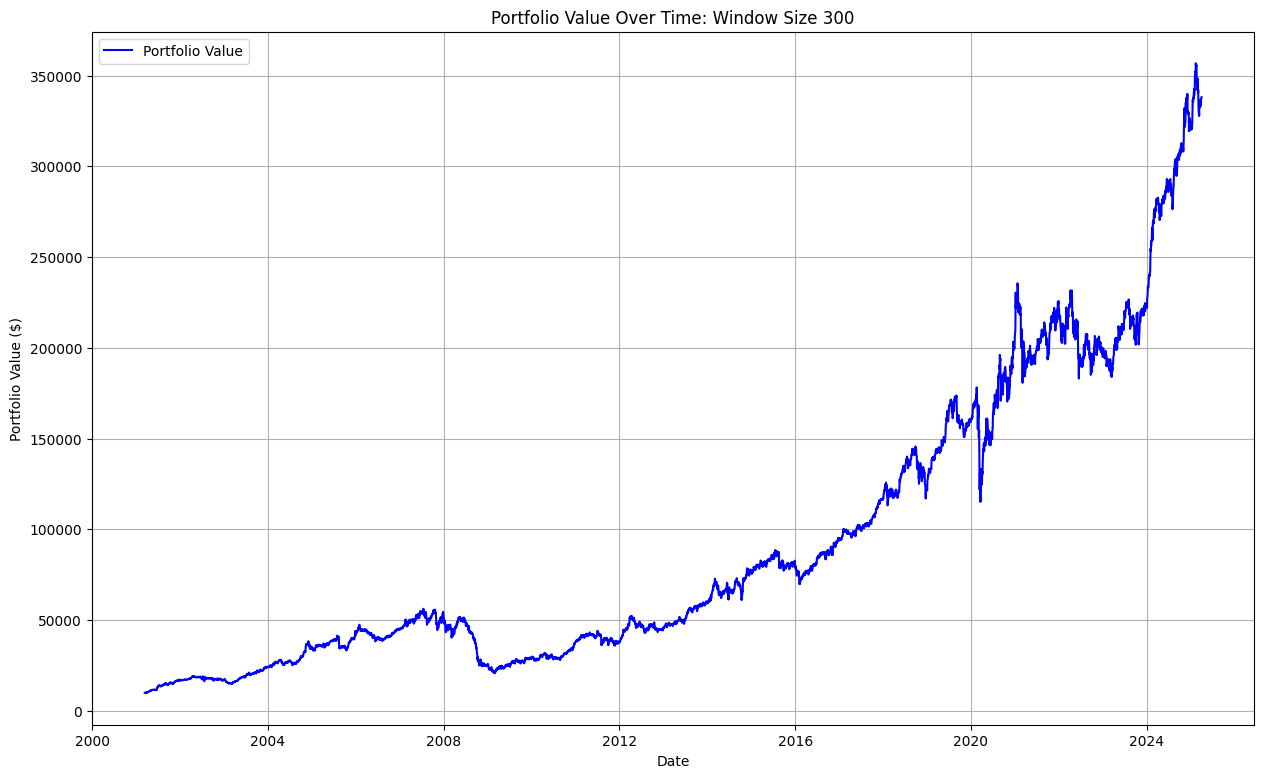

✅ Graph Finished


In [17]:
# Create MVO Portfolio Returns
plt.figure(figsize=(15, 9))
plt.plot(portfolio_values_df.index, portfolio_values_df['Portfolio Value'], label='Portfolio Value', color='b')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title(f'Portfolio Value Over Time: Window Size {window_size}')
plt.legend()
plt.grid(True)
plt.show()

print("✅ Graph Finished")


[*********************100%***********************]  1 of 1 completed


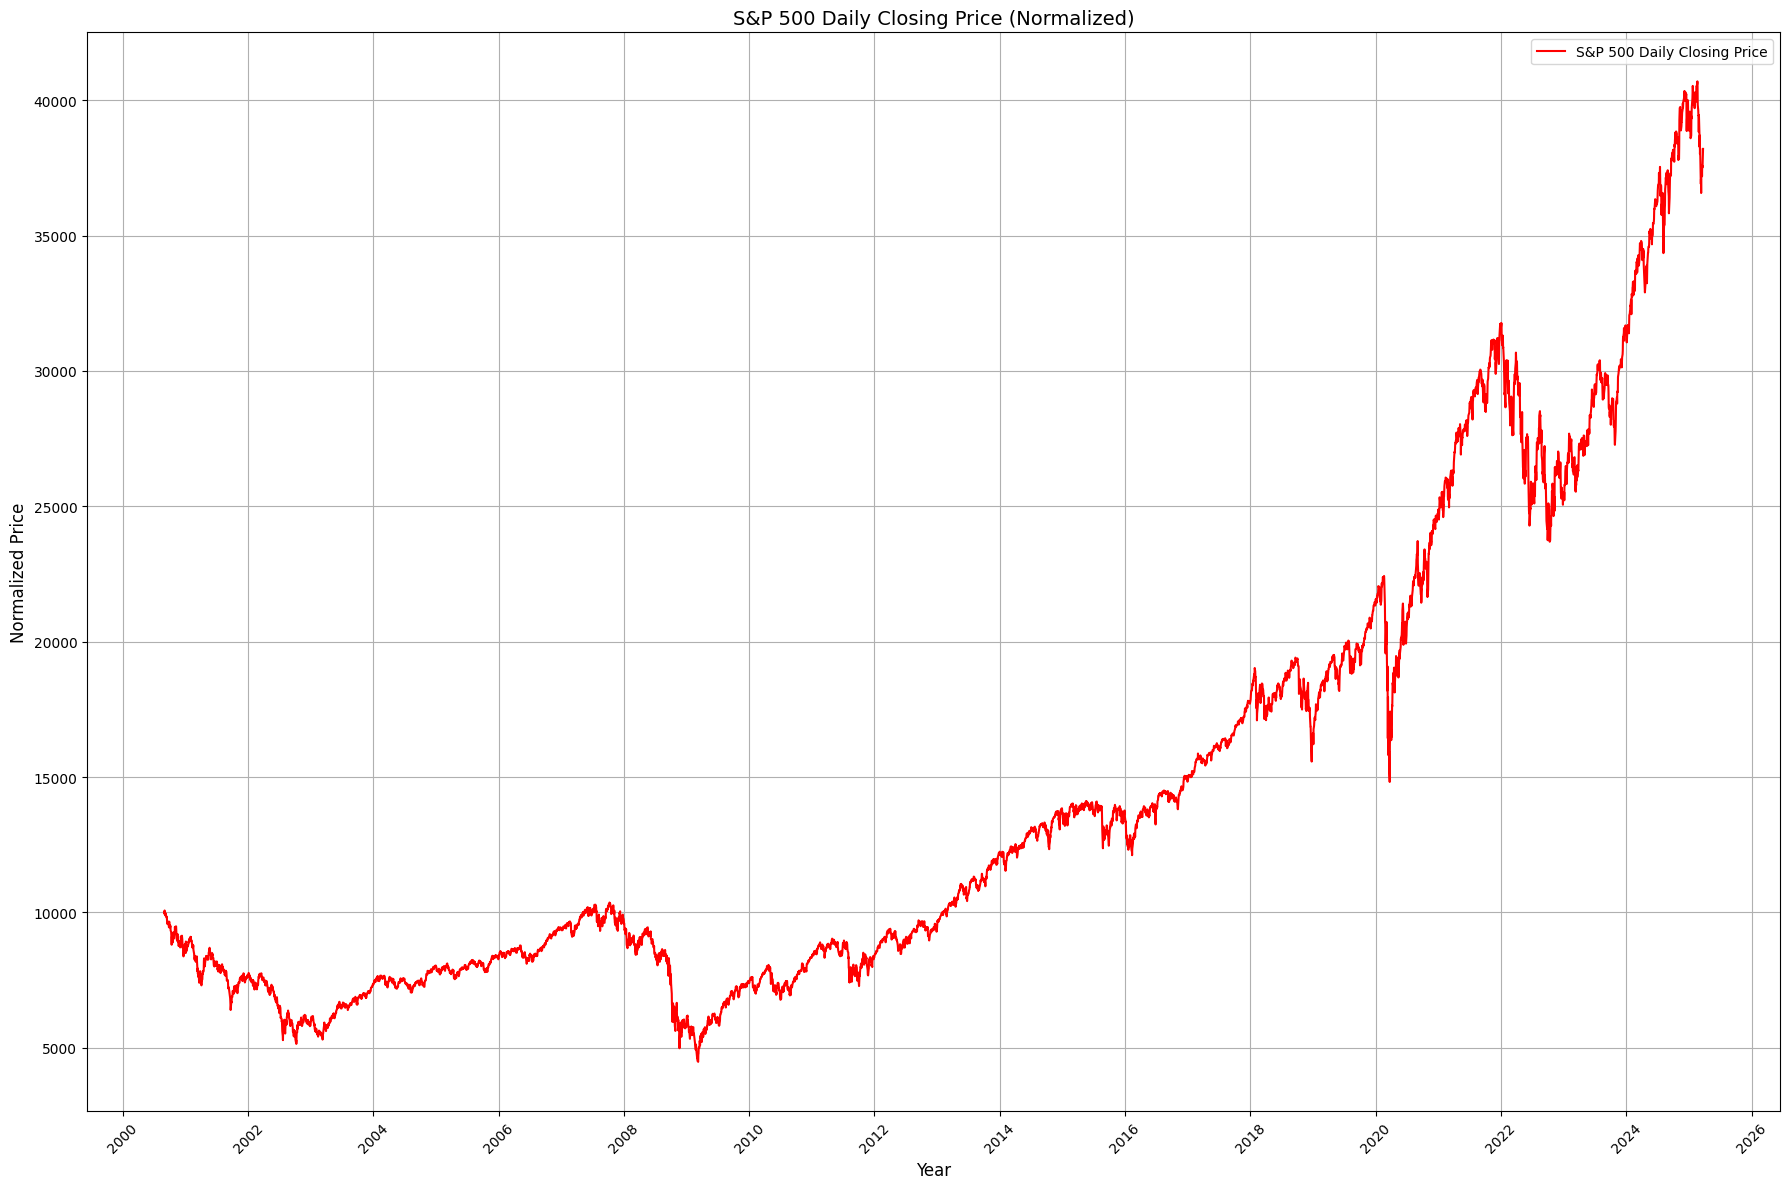

In [18]:
import matplotlib.dates as mdates
import yfinance as yf

# Download S&P 500 daily closing price data
data = yf.download('^GSPC', start='2000-08-29', end='2025-03-25')

# Get closing prices
close_prices = data['Close']

# Normalize closing prices: set the starting point to 10,000
normalized_close = 10000 * (close_prices / close_prices.iloc[0])

# Create chart
plt.figure(figsize=(18, 12))
plt.plot(close_prices.index, normalized_close, label='S&P 500 Daily Closing Price', color='r')

# Set x-axis to years
plt.xlabel('Year', fontsize=12)
plt.ylabel('Normalized Price', fontsize=12)
plt.title('S&P 500 Daily Closing Price (Normalized)', fontsize=14)

# Format x-axis: display a tick every 2 years
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  # One tick every 2 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Display only the year

# Beautify the plot
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)  # Rotate ticks to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [19]:
# Parameters
initial_capital = 10000
years = 25
target_date = "2025-02-18"

# Get final portfolio value from that date
final_value = portfolio_results.loc[target_date, 'Portfolio Value']

# Calculate CAGR
cagr = (final_value / initial_capital) ** (1 / years) - 1

# Print result as percentage
print(f"📈 CAGR over {years} years: {cagr:.4%}")

📈 CAGR over 25 years: 15.3603%


In [20]:
# Read and fix headers (for cosmatic reasons)
df_weight = pd.read_csv(f'{window_size}_optimal_weights_history_00_25.csv')
df_weight.columns.values[0] = 'Date'

df_value = pd.read_csv(f'{window_size}_portfolio_value_history_00_25.csv')
df_value.columns.values[0] = 'Date'

# Save back to same files
df_weight.to_csv(f'{window_size}_optimal_weights_history_00_25.csv', index=False)
df_value.to_csv(f'{window_size}_portfolio_value_history_00_25.csv', index=False)

print("✅ Column headers fixed and files saved.")


✅ Column headers fixed and files saved.
